In [1]:
import pandas as pd

# Dosyanın tüm sayfalarını okuyalım ve sayfa isimlerini listeyelim
xls = pd.ExcelFile("Tümü_acilis.xls")
df_kent = xls.parse('Kent açılış')
df_selva = xls.parse('Selva açılış')
df_TADFD = xls.parse('TADGD açılış')

# LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Veri setlerini yükleme ve ölçeklendirme
sheet_names = ['Kent açılış', 'Selva açılış', 'TADGD açılış']
data_frames = {name: pd.read_excel(xls, sheet_name=name) for name in sheet_names}
scalers = {name: MinMaxScaler(feature_range=(-1, 1)) for name in sheet_names}

# Her veri seti için ölçeklenmiş verileri hazırlama
data_scaled = {}
for name, df in data_frames.items():
    df.set_index('Tarih', inplace=True)
    data = df['Açılış'].values.astype(float)
    data_scaled[name] = scalers[name].fit_transform(data.reshape(-1, 1)).flatten()

def create_sequences(data, sequence_length=10):
    xs, ys = [], []
    for i in range(len(data)-sequence_length):
        x = data[i:(i+sequence_length)]
        y = data[i+sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# LSTM modelini tanımlayalım
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape, return_sequences=True),
        LSTM(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Her veri seti için model eğitimi ve tahminler
def predict_next_10_days(model, last_sequence, future_days=10):
    prediction_list = last_sequence.tolist()
    for _ in range(future_days):
        x = np.array(prediction_list[-10:]).reshape((1, 10, 1))
        out = model.predict(x)[0][0]
        prediction_list.append(out)
    return prediction_list[-future_days:]

predictions = {}
for name, data in data_scaled.items():
    X, y = create_sequences(data)
    lstm_model = build_lstm_model((X.shape[1], 1))
    lstm_model.fit(X, y, epochs=50, batch_size=64, verbose=1)
    
    # Son 10 günlük veriyi alarak 10 gün sonrasını tahmin edelim
    last_sequence = data[-10:]
    predicted_values = predict_next_10_days(lstm_model, last_sequence)
    predicted_values = scalers[name].inverse_transform(np.array(predicted_values).reshape(-1, 1)).flatten()
    
    # Tahmin tarihlerini oluşturalım
    start_date = pd.to_datetime('2024-01-01')
    prediction_dates = pd.date_range(start=start_date, periods=10, freq='D')
    predictions[name] = pd.DataFrame({
        'Tarih': prediction_dates,
        f'{name.split()[0]}_Tahmin': predicted_values
    })

# Tahminleri birleştirme
combined_predictions = predictions['Kent açılış']
for name in ['Selva açılış', 'TADGD açılış']:
    combined_predictions = combined_predictions.merge(predictions[name], on='Tarih')

combined_predictions


Epoch 1/50


C:\Users\Administrator\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.4298
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1140
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0112
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0063
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0060
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0054
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0052
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0046
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0046
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0045
Epoch 13/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0040
Epoch 14/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039
Epoch 15/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033
Epoch 16/50
20/20 ━━━━━━━━━━━━

C:\Users\Administrator\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


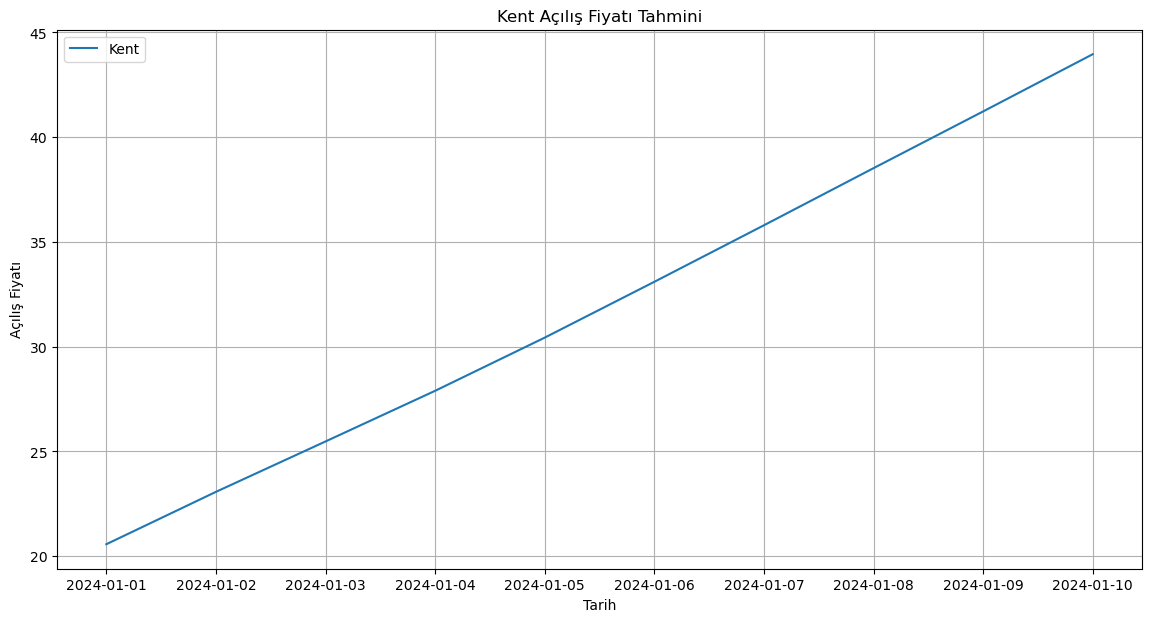

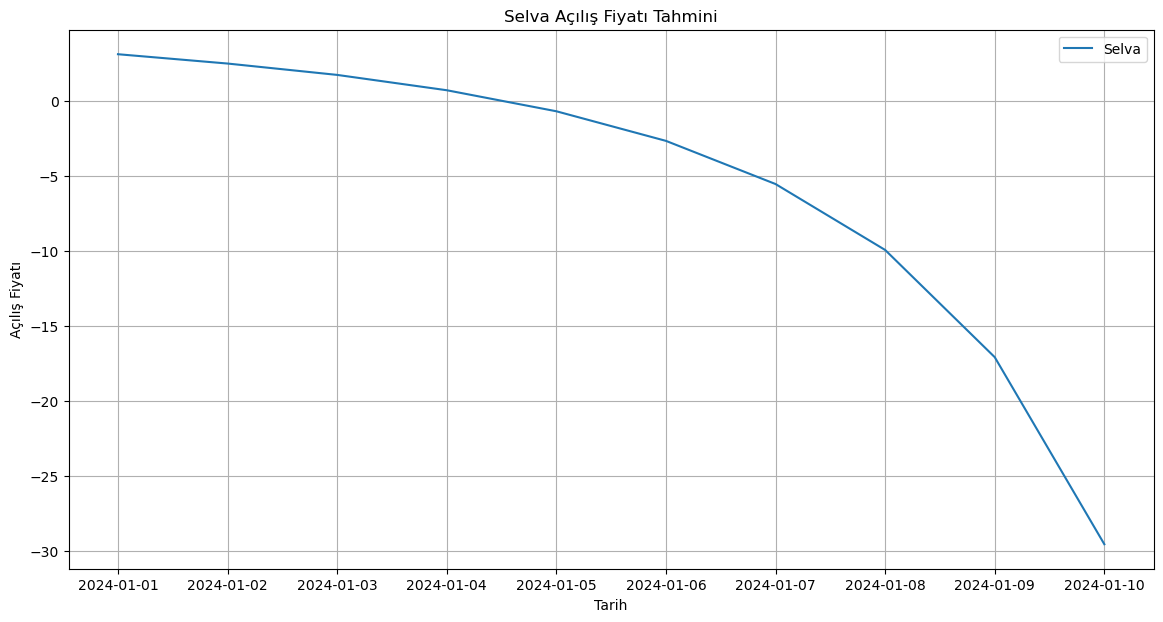

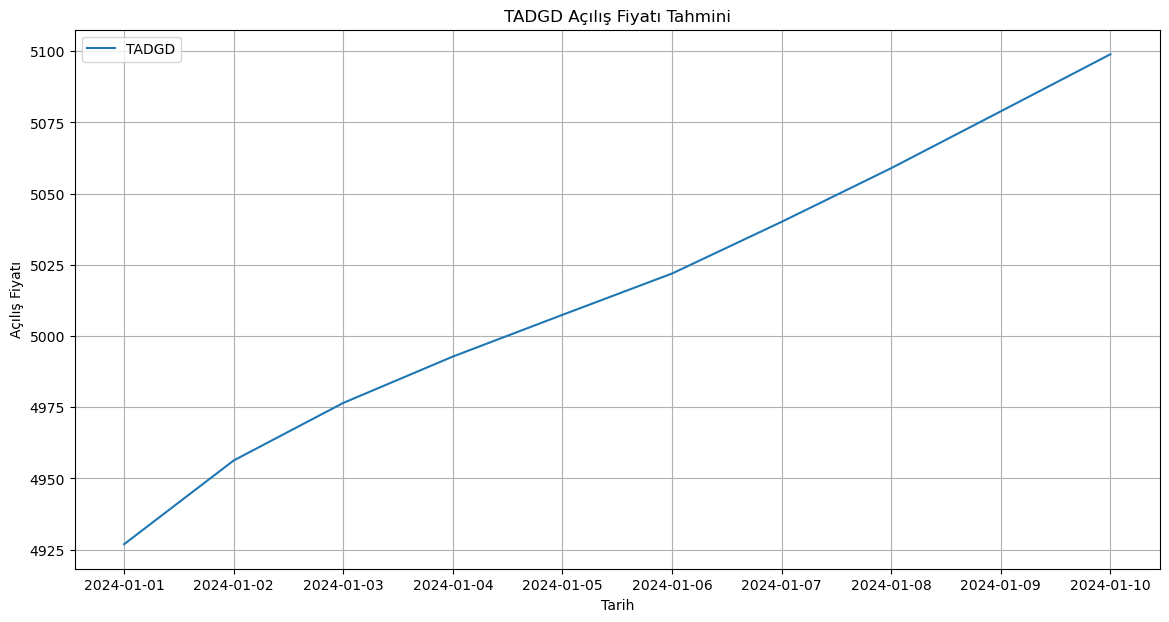

In [10]:
import matplotlib.pyplot as plt

# Kent açılış tahmin grafiği
plt.figure(figsize=(14, 7))
plt.plot(predictions['Kent açılış']['Tarih'], predictions['Kent açılış']['Kent_Tahmin'], label='Kent')
plt.title('Kent Açılış Fiyatı Tahmini')
plt.xlabel('Tarih')
plt.ylabel('Açılış Fiyatı')
plt.legend()
plt.grid(True)
plt.show()

# Selva açılış tahmin grafiği
plt.figure(figsize=(14, 7))
plt.plot(predictions['Selva açılış']['Tarih'], predictions['Selva açılış']['Selva_Tahmin'], label='Selva')
plt.title('Selva Açılış Fiyatı Tahmini')
plt.xlabel('Tarih')
plt.ylabel('Açılış Fiyatı')
plt.legend()
plt.grid(True)
plt.show()

# TADGD açılış tahmin grafiği
plt.figure(figsize=(14, 7))
plt.plot(predictions['TADGD açılış']['Tarih'], predictions['TADGD açılış']['TADGD_Tahmin'], label='TADGD')
plt.title('TADGD Açılış Fiyatı Tahmini')
plt.xlabel('Tarih')
plt.ylabel('Açılış Fiyatı')
plt.legend()
plt.grid(True)
plt.show()
